# Intro to Object Detection Colab

Welcome to the object detection colab!  This demo will take you through the steps of running an "out-of-the-box" detection model on a collection of images.

## Imports and Setup

In [ ]:
!pip install -U --pre tensorflow=="2.2.0"

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

## Utilities

In [2]:
from utilities import *

In [3]:
# @title Choose the model to use, then evaluate the cell.
MODELS = {'centernet_with_keypoints': 'center_net_hg104_512x512_kpts_coco17_tpu-32', 'centernet_without_keypoints': 'center_net_hg104_512x512_coco17_tpu-8'}

model_display_name = 'centernet_with_keypoints' # @param ['centernet_with_keypoints', 'centernet_without_keypoints']
model_name = MODELS[model_display_name]

### Build a detection model and load pre-trained model weights

This sometimes takes a little while, please be patient!

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

if model_display_name == 'centernet_with_keypoints':
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
  !tar -xf centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
  !mv centernet_hg104_512x512_kpts_coco17_tpu-32/checkpoint models/research/object_detection/test_data/
else:
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz
  !tar -xf centernet_hg104_512x512_coco17_tpu-8.tar.gz
  !mv centernet_hg104_512x512_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

In [4]:
import os 
pipeline_config = os.path.join('models/research/object_detection/configs/tf2/',
                                'center_net_hourglass104_512x512_coco17_tpu-8' + '.config')
model_dir = 'models/research/object_detection/test_data/checkpoint/'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

# Load label map data (for plotting).

Label maps correspond index numbers to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

In [5]:
label_map_dict, label_map_path, category_index = load_label_map(configs)

### Putting everything together!

Run the below code which loads an image, runs it through the detection model and visualizes the detection results, including the keypoints.

Note that this will take a long time (several minutes) the first time you run this code due to tf.function's trace-compilation --- on subsequent runs (e.g. on new images), things will be faster.

Here are some simple things to try out if you are curious:
* Try running inference on your own images (local paths work)
* Modify some of the input images and see if detection still works.  Some simple things to try out here (just uncomment the relevant portions of code) include flipping the image horizontally, or converting to grayscale (note that we still expect the input image to have 3 channels).
* Print out `detections['detection_boxes']` and try to match the box locations to the boxes in the image.  Notice that coordinates are given in normalized form (i.e., in the interval [0, 1]).
* Set min_score_thresh to other values (between 0 and 1) to allow more detections in or to filter out more detections.

Note that you can run this cell repeatedly without rerunning earlier cells.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


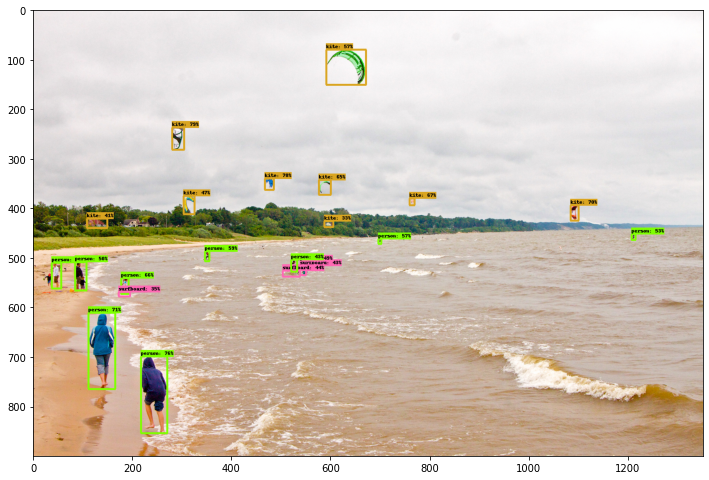

In [6]:
image_dir = 'models/research/object_detection/test_images/'
image_path = os.path.join(image_dir, 'image2.jpg')
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections:
  keypoints = detections['detection_keypoints'][0].numpy()
  keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=get_keypoint_tuples(configs['eval_config']))

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

## Digging into the model's intermediate predictions

For this part we will assume that the detection model is a CenterNet model following Zhou et al (https://arxiv.org/abs/1904.07850).  And more specifically, we will assume that `detection_model` is of type `meta_architectures.center_net_meta_arch.CenterNetMetaArch`.

As one of its intermediate predictions, CenterNet produces a heatmap of box centers for each class (for example, it will produce a heatmap whose size is proportional to that of the image that lights up at the center of each, e.g., "zebra"). In the following, we will visualize these intermediate class center heatmap predictions.

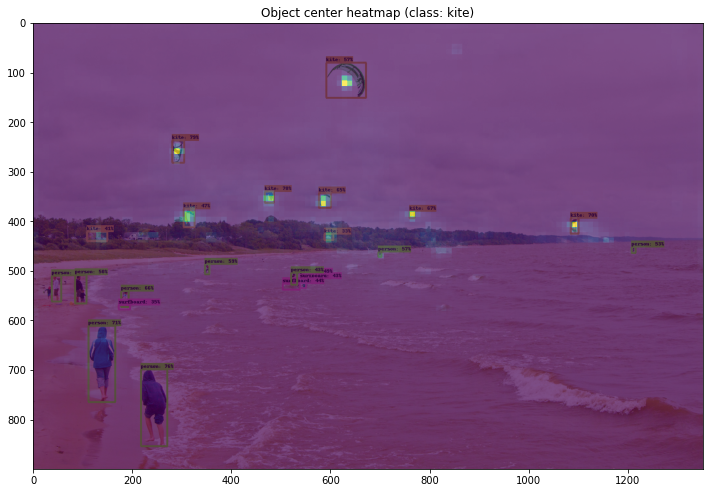

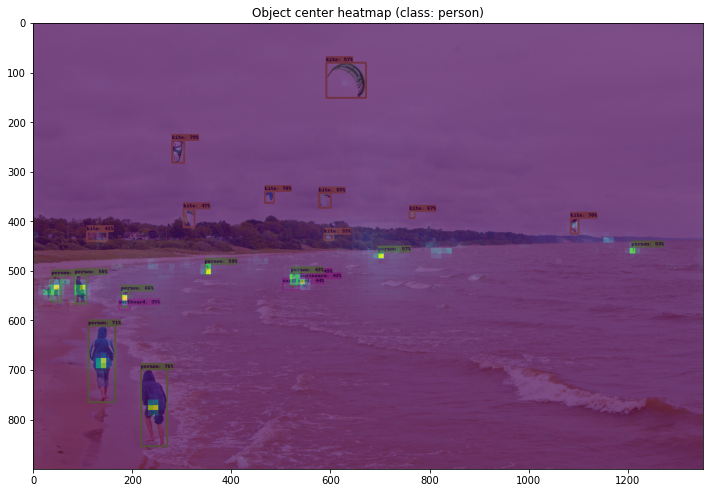

In [7]:
if detection_model.__class__.__name__ != 'CenterNetMetaArch':
  raise AssertionError('The meta-architecture for this section '
  'is assumed to be CenterNetMetaArch!')


class_name = 'kite'
heatmap = get_heatmap(predictions_dict, class_name, label_map_dict, label_id_offset)
resized_heatmap_unpadded = unpad_heatmap(heatmap, image_np, detection_model, shapes)
plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.imshow(resized_heatmap_unpadded, alpha=0.7,vmin=0, vmax=160, cmap='viridis')
plt.title('Object center heatmap (class: ' + class_name + ')')
plt.show()

class_name = 'person'
heatmap = get_heatmap(predictions_dict, class_name, label_map_dict, label_id_offset)
resized_heatmap_unpadded = unpad_heatmap(heatmap, image_np, detection_model, shapes)
plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.imshow(resized_heatmap_unpadded, alpha=0.7,vmin=0, vmax=160, cmap='viridis')
plt.title('Object center heatmap (class: ' + class_name + ')')
plt.show()

In [17]:
STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]

In [14]:
classes_detected = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)

{'GoldenRod': 'kite', 'Chartreuse': 'person', 'HotPink': 'surfboard'}


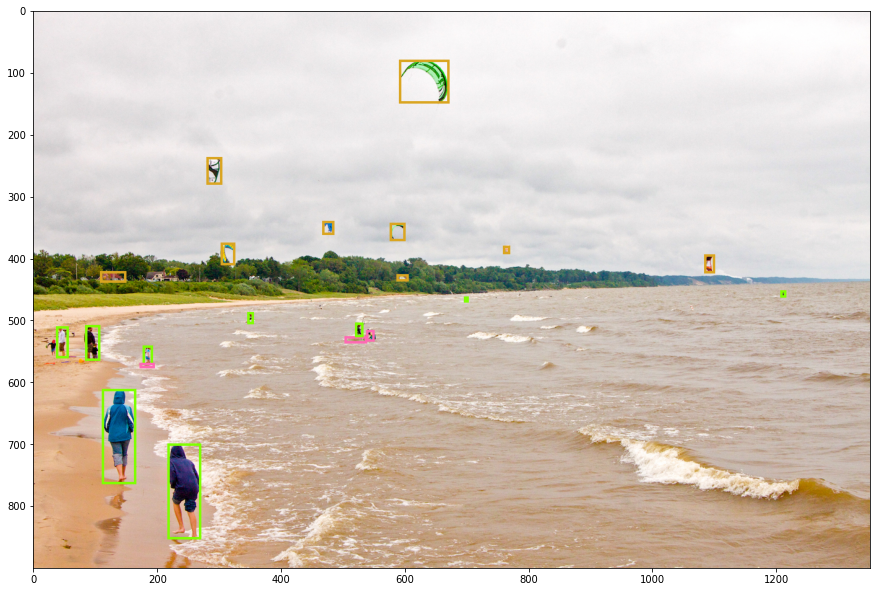

In [37]:

from matplotlib.pyplot import imshow

detected_classes_text = {}

test_image = 'models/research/object_detection/test_images/image2.jpg'
pil_im = Image.open(test_image)
im_width, im_height = pil_im.size

draw = ImageDraw.Draw(pil_im)

scores = detections['detection_scores'][0].numpy()

for idx, bbox in enumerate(detections['detection_boxes'][0].numpy()):  
    if scores[idx] > 0.30:
        box = tuple(bbox.tolist())
        ymin, xmin, ymax, xmax = box
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)

        draw.rectangle(((left, top), (right, bottom)), width=4, outline=STANDARD_COLORS[classes_detected[idx]])   

        detected_classes_text[STANDARD_COLORS[classes_detected[idx]]] = category_index[classes_detected[idx]]['name']

plt.figure(figsize=(15,20))
plt.imshow(pil_im)

print(detected_classes_text)

    

{'GoldenRod': 'kite', 'Chartreuse': 'person', 'HotPink': 'surfboard'}
587.8916239738464 606.2180514335632 426.09309554100037 437.41038143634796
(900, 1352)


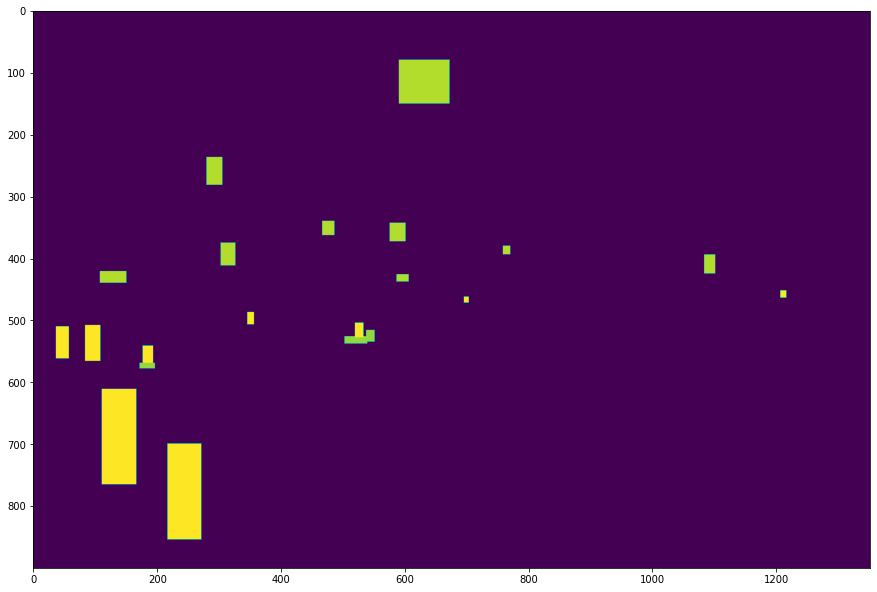

In [46]:

from matplotlib.pyplot import imshow

detected_classes_text = {}

classes_weight = {
    "kite": 2,
    "person": 10,
    "surfboard":1
}

test_image = 'models/research/object_detection/test_images/image2.jpg'
orig_im = Image.open(test_image)
im_width, im_height = pil_im.size
pil_im = Image.new('L', (im_width, im_height))

draw = ImageDraw.Draw(pil_im)

scores = detections['detection_scores'][0].numpy()

for idx, bbox in enumerate(detections['detection_boxes'][0].numpy()):  
    if scores[idx] > 0.30:
        box = tuple(bbox.tolist())
        ymin, xmin, ymax, xmax = box
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)

        draw.rectangle(
            ((left, top), (right, bottom)), 
            outline=STANDARD_COLORS[classes_detected[idx]],
            fill=STANDARD_COLORS[classes_detected[idx]]
        )   

        detected_classes_text[STANDARD_COLORS[classes_detected[idx]]] = category_index[classes_detected[idx]]['name']

plt.figure(figsize=(15,20))
plt.imshow(pil_im)

print(detected_classes_text)
print(left, right, top, bottom)
print(np.asarray(pil_im).shape)

    

(900, 1352)
{'GoldenRod': 'kite', 'Chartreuse': 'person', 'HotPink': 'surfboard'}


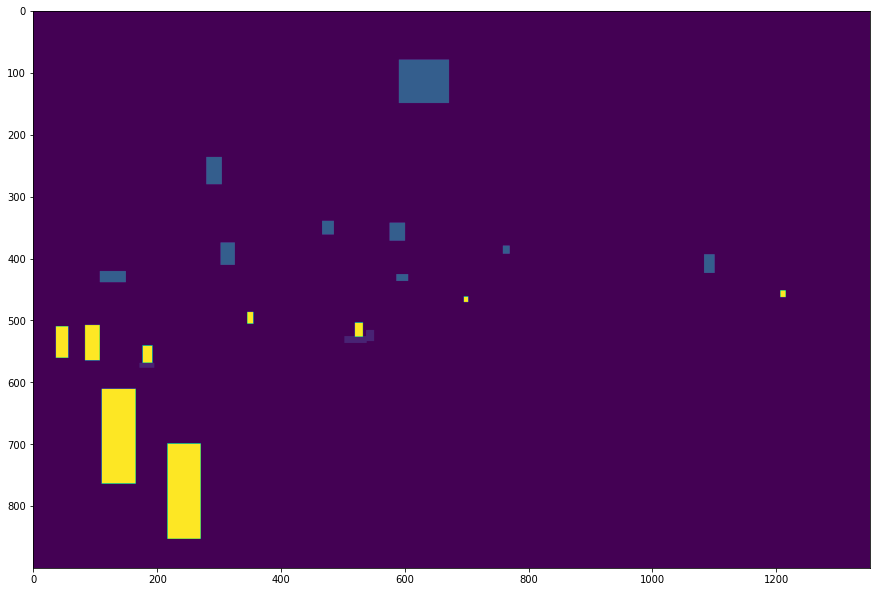

In [85]:
detected_classes_text = {}

classes_weight = {
    "kite": 3,
    "person": 10,
    "surfboard":1
}

test_image = 'models/research/object_detection/test_images/image2.jpg'
orig_im = Image.open(test_image)
im_width, im_height = pil_im.size
pil_im = Image.new('L', (im_width, im_height))

np_im = np.asarray(pil_im).copy()
print(np_im.shape)

scores = detections['detection_scores'][0].numpy()

for idx, bbox in enumerate(detections['detection_boxes'][0].numpy()):  
    if scores[idx] > 0.30:
        ymin, xmin, ymax, xmax = tuple(bbox.tolist())
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)

        obj_score = classes_weight[category_index[classes_detected[idx]]['name']]
        np_im[int(top):int(bottom),int(left):int(right)] = obj_score

        detected_classes_text[STANDARD_COLORS[classes_detected[idx]]] = category_index[classes_detected[idx]]['name']

plt.figure(figsize=(15,20))
plt.imshow(np_im)

print(detected_classes_text)


In [80]:
def make_crop_coordinates(image):
    height = image.shape[0]
    width = image.shape[1]
    coodinates = []
    shorter_dimension = min(width, height)
    position_step = shorter_dimension / 80
    sizes = [shorter_dimension * 0.8,
             shorter_dimension * 0.9, shorter_dimension]
    for size in sizes:
        position_width = 0
        while True:
            position_height = 0
            while True:
                coodinates.append((position_width, position_height,
                                   position_width + size, position_height + size))
                position_height += position_step
                if position_height > height - size:
                    break
            position_width += position_step
            if position_width > width - size:
                break
    return coodinates

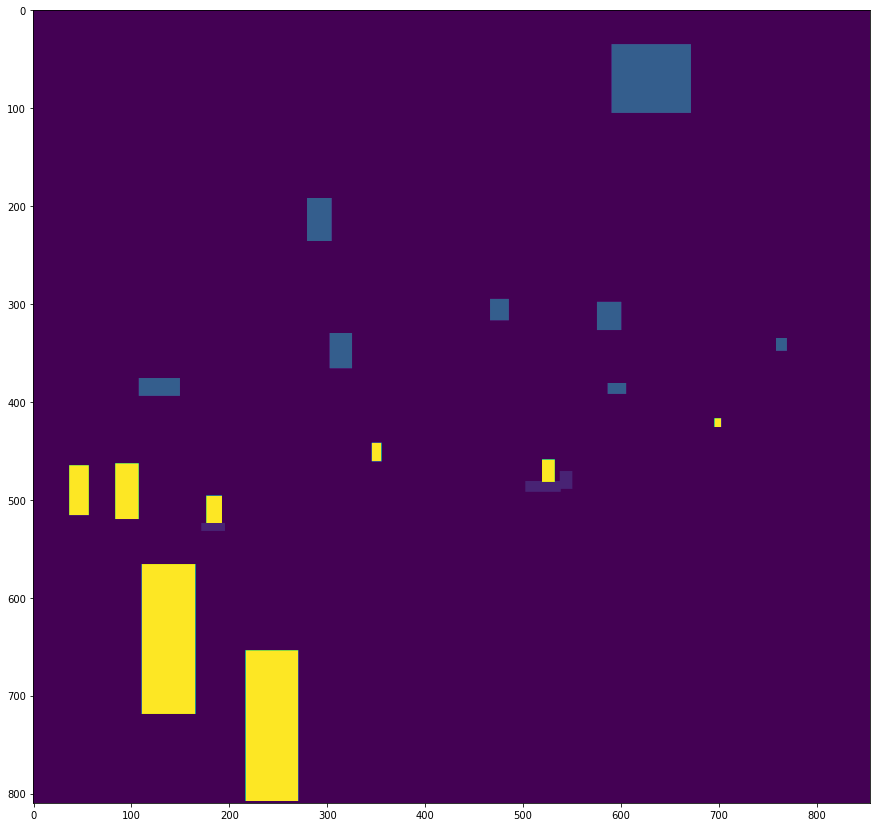

In [86]:
crops = make_crop_coordinates(np_im)

best_score = -1
best_crop = []

for crop in crops:
    candidate_score = np.sum(np_im[int(crop[0]):int(crop[2]),int(crop[1]):int(crop[2])])
    if best_score < candidate_score:
        best_crop = crop
        best_score = candidate_score
        

plt.figure(figsize=(15,20))
plt.imshow(np_im[int(best_crop[0]):int(best_crop[2]),int(best_crop[1]):int(best_crop[2])])